In [31]:
import random
import math
import matplotlib.pyplot as plt
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import array
import numpy


In [32]:
class Particle:
    def __init__(self, dimension, l_bound, h_bound):

        self.position = [random.uniform(l_bound, h_bound) for _ in range(dimension)]

        vmax = 0.1 * (h_bound - l_bound)
        self.velocity = [random.uniform(-vmax, vmax) for _ in range(dimension)]

        self.p_best = self.position.copy()
        self.g_best = None

        self.fitness = float('inf')
        self.b_fitness = float('inf')


    def calc_new_velocity(self, r1, r2, a_co1, a_co2):

        cog_component = [r1 * a_co1 * (p - x) for p, x in zip(self.p_best, self.position)]

        soc_component = [r2 * a_co2 * (g - x) for g, x in zip(self.g_best, self.position)]

        self.velocity = [v + c + s for v, c, s in zip(self.velocity, cog_component, soc_component)]

    
    def calc_new_position(self, r1, r2, a_co1, a_co2):

        self.calc_new_velocity(r1, r2, a_co1, a_co2)

        self.position = [x + v for x, v in zip(self.position, self.velocity)]
        

In [33]:
def PSO(dimension, fitness, swarm_size, l_bound, h_bound, a_co1, a_co2, max_iter=100, seed=100):

    rnd = random.Random(seed)
    swarm = [Particle(dimension, l_bound, h_bound) for _ in range(swarm_size)]

    best_fitnesses = []

    best_position = None
    best_fitness = float('inf')  # minimize fitness

    for _ in range(max_iter):
        for particle in swarm:
            particle.fitness = fitness(particle.position)

            # Update personal best
            if (particle.p_best is None) or (particle.fitness < particle.b_fitness):
                particle.p_best = particle.position.copy()
                particle.b_fitness = particle.fitness

            # Update global best
            if (best_position is None) or (particle.fitness < best_fitness):
                best_position = particle.position.copy()
                best_fitness = particle.fitness
            

        # Update velocities and positions
        for particle in swarm:
            particle.g_best = best_position.copy()
            r1 = rnd.random()
            r2 = rnd.random()
            particle.calc_new_position(r1, r2, a_co1, a_co2)
        
        # Logs best fitness for logging
        best_fitnesses.append(best_fitness)

    return (best_position, best_fitness, best_fitnesses)


In [34]:
import array
import random
import numpy as np
from deap import base, creator, tools

def DE(dimension, fitness, swarm_size, l_bound, h_bound, F, CR, max_iter=100, seed=None):

    if seed is not None:
        random.seed(seed)       # Python random
        np.random.seed(seed) 

    # Avoid re-creating creator in the same session
    try:
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    except:
        pass
    try:
        creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)
    except:
        pass

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, l_bound, h_bound)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, dimension)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selRandom, k=3)
    toolbox.register("evaluate", fitness)

    pop = toolbox.population(n=swarm_size)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    # Evaluate initial population
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = (fit,)

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(pop), **record)
    print(logbook.stream)

    # Main DE loop
    for g in range(1, max_iter):
        for k, agent in enumerate(pop):
            # Select three distinct individuals
            a, b, c = toolbox.select(pop)
            y = toolbox.clone(agent)
            j_rand = random.randrange(dimension)
            for i in range(dimension):
                if i == j_rand or random.random() < CR:
                    y[i] = a[i] + F * (b[i] - c[i])
            # Evaluate trial vector
            y.fitness.values = (toolbox.evaluate(y),)
            # Selection: minimize
            if y.fitness.values[0] < agent.fitness.values[0]:
                pop[k] = y

        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=g, evals=len(pop), **record)
        print(logbook.stream)

    return logbook, hof


In [35]:
def rosenbrock_fitness(x):
    D = len(x)

    total = 0.0
    
    for i in range(D-1):
        total += 100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2
    return total

def griewank_fitness(x):

    sum_term = sum(xi**2 / 4000 for xi in x)

    prod_term = 1.0

    for i, xi in enumerate(x, start=1):
        prod_term *= math.cos(xi / math.sqrt(i))
    return sum_term - prod_term + 1

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def table_and_avg_plot(seed_res):

    final_bests = []
    all_best_values = []

    # --- Collect per-seed results ---
    for res in seed_res:
        seed = res['seed']
        best_values = res['best_values']
        final_bests.append(best_values[-1])
        all_best_values.append(best_values)

    # --- Average over seeds ---
    # Pad shorter runs with NaN if seeds have different lengths
    max_len = max(len(v) for v in all_best_values)
    arr = np.full((len(all_best_values), max_len), np.nan)
    for i, v in enumerate(all_best_values):
        arr[i, :len(v)] = v
    
    mean_over_gens = np.nanmean(arr, axis=0)
    std_over_gens = np.nanstd(arr, axis=0)

    # --- Plot only average curve ---
    plt.figure(figsize=(8,5))
    gens = np.arange(1, len(mean_over_gens)+1)
    plt.plot(gens, mean_over_gens, label="Mean Best Fitness")
    plt.fill_between(gens,
                     mean_over_gens - std_over_gens,
                     mean_over_gens + std_over_gens,
                     alpha=0.3, label="±1 Std Dev")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Average Best Fitness Across Seeds")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Create table with best individuals ---
    df = pd.DataFrame({
        'Seed': [res['seed'] for res in seed_res],
        'Best Individual': final_bests
    })

    # Append mean and std at the bottom
    summary_row = pd.DataFrame({
        'Seed': ['Mean', 'Std'],
        'Best Individual': [np.mean(final_bests), np.std(final_bests)]
    })

    final_table = pd.concat([df, summary_row], ignore_index=True)
    return final_table


In [37]:
def plot_fitness(fitnesses, title="Fitness Over Epochs"):
    plt.figure(figsize=(10, 6))
    plt.plot(fitnesses, label="Fitness")
    plt.xlabel("Epoch")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

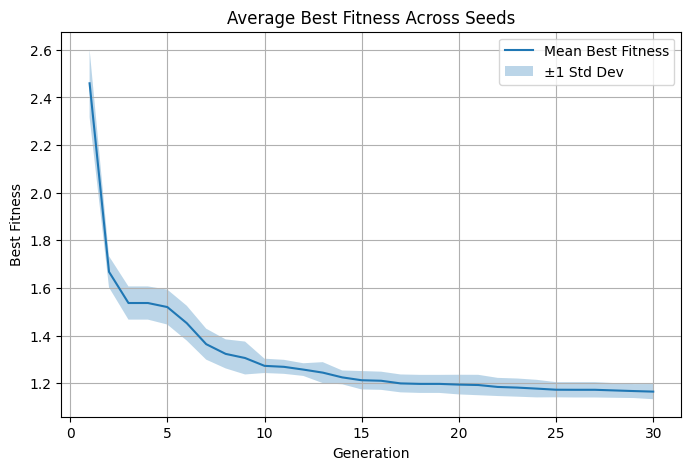

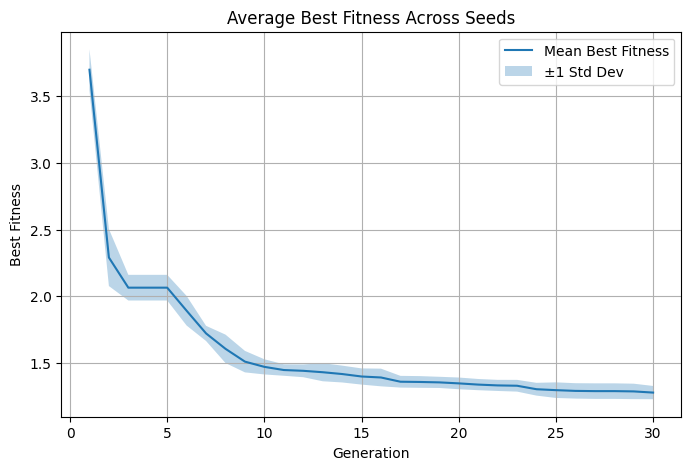

,Seed,Best Individual
0,500,1.266654
1,1000,1.307499
2,1500,1.260656
3,2000,1.201064
4,2500,1.350004
5,Mean,1.277176
6,Std,0.049800


In [38]:
def run_seed_PSO(dimension,fitness, seeds=[500,1000,1500,2000,2500]):

    seed_res = []

    for seed in seeds:
        
        (best_position, best_fitness, best_fitnesses)  = PSO(dimension,fitness, 50, -30, 30, 0.5,0.8, max_iter=30, seed=seed)

        seed_res.append({
            "seed":seed,
            "best_values": best_fitnesses
        })

    return seed_res


seedd_res = run_seed_PSO(30, griewank_fitness)
table_and_avg_plot(seedd_res)

seedd_res = run_seed_PSO(50, griewank_fitness)
table_and_avg_plot(seedd_res)

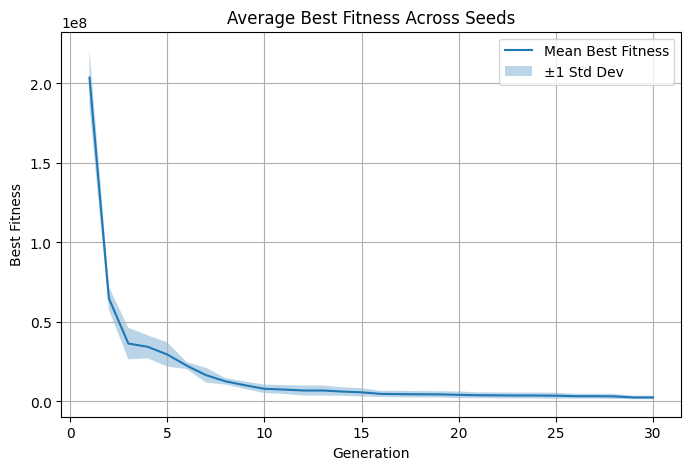

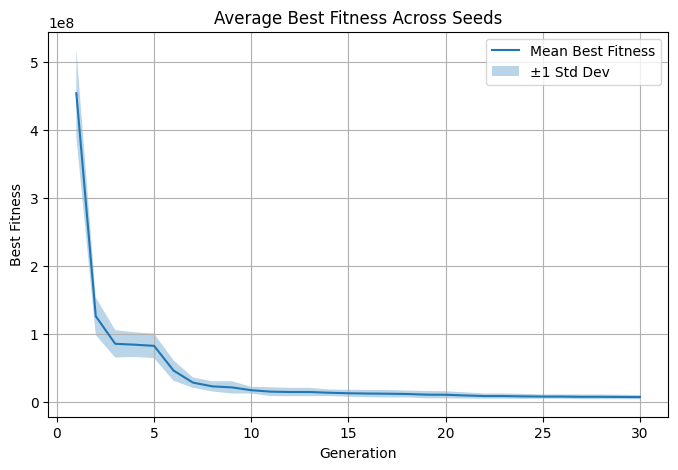

,Seed,Best Individual
0,500,8.888487e+06
1,1000,1.249190e+07
2,1500,4.088196e+06
3,2000,4.874743e+06
4,2500,5.450596e+06
5,Mean,7.158784e+06
6,Std,3.130406e+06


In [39]:
seedd_res = run_seed_PSO(30, rosenbrock_fitness)
table_and_avg_plot(seedd_res)

seedd_res = run_seed_PSO(50, rosenbrock_fitness)
table_and_avg_plot(seedd_res)

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	std        	min       	avg        	max       
0  	50   	1.13656e+08	2.2377e+08	4.48508e+08	7.7685e+08
1  	50   	1.16205e+08	2.2377e+08	4.4265e+08 	7.7685e+08
2  	50   	1.17701e+08	1.22606e+08	4.24166e+08	6.5495e+08
3  	50   	1.13005e+08	1.22606e+08	4.19725e+08	6.40097e+08
4  	50   	1.26571e+08	4.40544e+07	4.06062e+08	6.40097e+08
5  	50   	1.45415e+08	4.40544e+07	3.64781e+08	6.39372e+08
6  	50   	1.49475e+08	4.40544e+07	3.49295e+08	6.39372e+08
7  	50   	1.57355e+08	2.74453e+07	3.06169e+08	6.39372e+08
8  	50   	1.4617e+08 	2.74453e+07	2.67562e+08	5.48491e+08
9  	50   	1.43889e+08	2.74453e+07	2.35292e+08	5.48491e+08
10 	50   	1.30397e+08	2.74453e+07	2.06003e+08	5.48491e+08
11 	50   	1.06193e+08	2.37574e+07	1.71948e+08	4.32892e+08
12 	50   	8.26598e+07	1.57289e+07	1.09134e+08	4.32892e+08
13 	50   	6.36346e+07	1.40894e+07	8.27473e+07	2.89965e+08
14 	50   	5.35385e+07	1.40894e+07	6.2249e+07 	2.89965e+08
15 	50   	2.60802e+07	1.02584e+07	4.3029e+07 	1.25947e+08
16 	50   	2.06889e+07

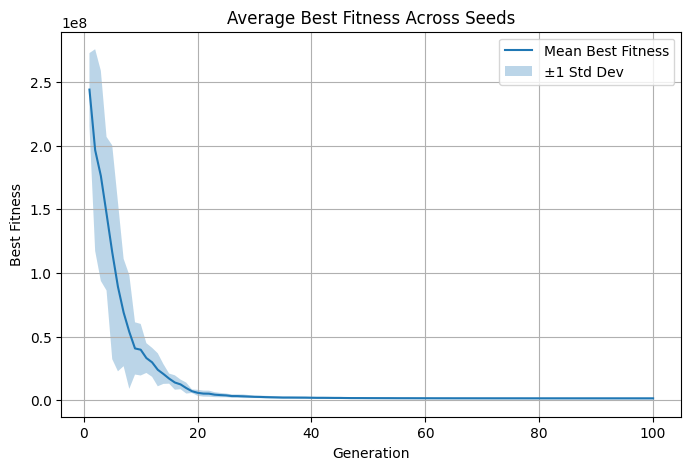

gen	evals	std        	min        	avg        	max        
0  	50   	1.50849e+08	4.82359e+08	7.56029e+08	1.16413e+09
1  	50   	1.7614e+08 	2.53921e+08	7.32167e+08	1.16413e+09
2  	50   	1.90588e+08	2.08187e+08	7.206e+08  	1.16413e+09
3  	50   	1.9479e+08 	2.08187e+08	7.12703e+08	1.16413e+09
4  	50   	2.12439e+08	2.08187e+08	6.90991e+08	1.16413e+09
5  	50   	2.36646e+08	2.08187e+08	6.43988e+08	1.02442e+09
6  	50   	2.47935e+08	1.48211e+08	6.33748e+08	1.02442e+09
7  	50   	2.42264e+08	1.48211e+08	6.06069e+08	1.02442e+09
8  	50   	2.56827e+08	4.51314e+07	5.55227e+08	1.02442e+09
9  	50   	2.85649e+08	2.5539e+07 	5.12729e+08	1.02442e+09
10 	50   	2.78821e+08	2.5539e+07 	4.70806e+08	1.02442e+09
11 	50   	2.46219e+08	2.5539e+07 	3.86849e+08	9.14371e+08
12 	50   	1.9332e+08 	2.5539e+07 	3.03649e+08	7.8737e+08 
13 	50   	1.2921e+08 	2.00529e+07	2.1512e+08 	5.89533e+08
14 	50   	1.11052e+08	9.40313e+06	1.88293e+08	4.98685e+08
15 	50   	1.05753e+08	9.40313e+06	1.56192e+08	4.28689e+08
16 	50   	8.00

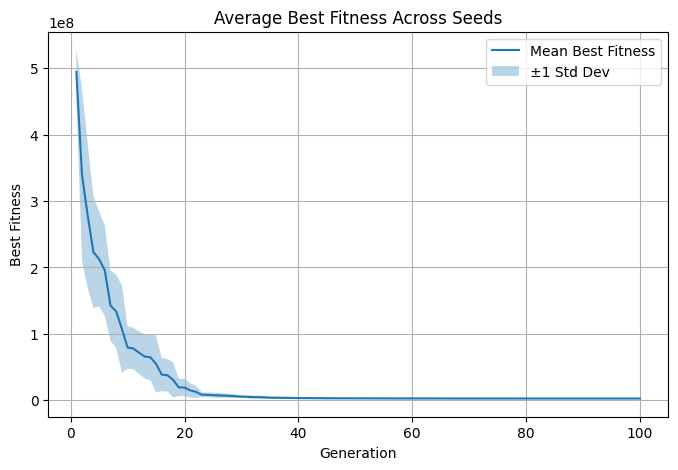

,Seed,Best Individual
0,500,3.377544e+06
1,1000,3.516091e+06
2,1500,1.200659e+06
3,2000,3.452591e+06
4,2500,1.324578e+06
5,Mean,2.574293e+06
6,Std,1.072591e+06


In [ ]:
def run_seed_DE(dimension,fitness, seeds=[500,1000,1500,2000,2500]):

    seed_res = []

    for seed in seeds:
        
        (logbook,hfa) = DE(dimension,fitness, 50, -30, 30, 0.5,1, seed=seed)

        seed_res.append({
            "seed":seed,
            "best_values": logbook.select("min")
        })

    return seed_res


seedd_res = run_seed_DE(30, griewank_fitness)
table_and_avg_plot(seedd_res)

seedd_res = run_seed_DE(50, griewank_fitness)
table_and_avg_plot(seedd_res)



In [ ]:
seedd_res = run_seed_DE(30, rosenbrock_fitness)
table_and_avg_plot(seedd_res)

seedd_res = run_seed_DE(50, rosenbrock_fitness)
table_and_avg_plot(seedd_res)